<font color='Blue'>First thing we gonna do is we will find the keypoint using the SIFT algorithm libary<br><br>
We will start with imports and read the images and display them.<font>


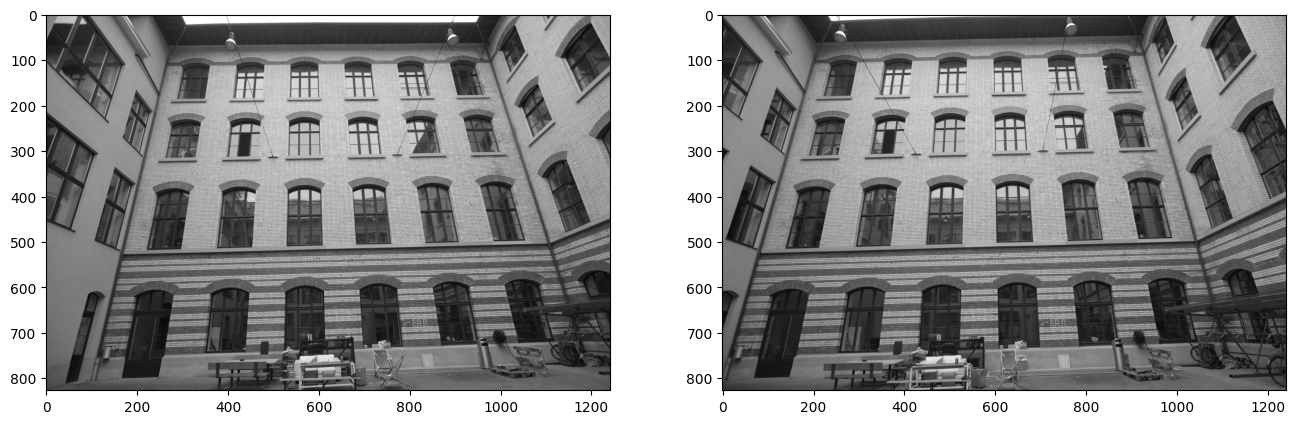

In [245]:
import cv2 
import matplotlib.pyplot as plt

img1_path = 'example_1/I1.png'
img2_path = 'example_1/I2.png'

# read images
img1 = cv2.imread(img1_path)  
img2 = cv2.imread(img2_path) 

#display tehm
figure, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

<font color='Blue'>NOW first Question what we are going to do is to find the Keypoints in both images<Br>
We will Use the SIFT algorithm to detect the keypoint<br><br>
first we create a SIFT object using sift_create and then use the function detectAndCompute to get the keypoints. It will return two values – the keypoints and the sift computer vision descriptors..<font>


In [246]:
# SIFT
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

# Print the number of keypoints detected in each image
print("Length of keypoints_1:", len(keypoints_1))
print("Length of keypoints_2:", len(keypoints_2))

Length of keypoints_1: 5766
Length of keypoints_2: 6427


<font color='Blue'>here is the images drawn on them the keypoints <font>

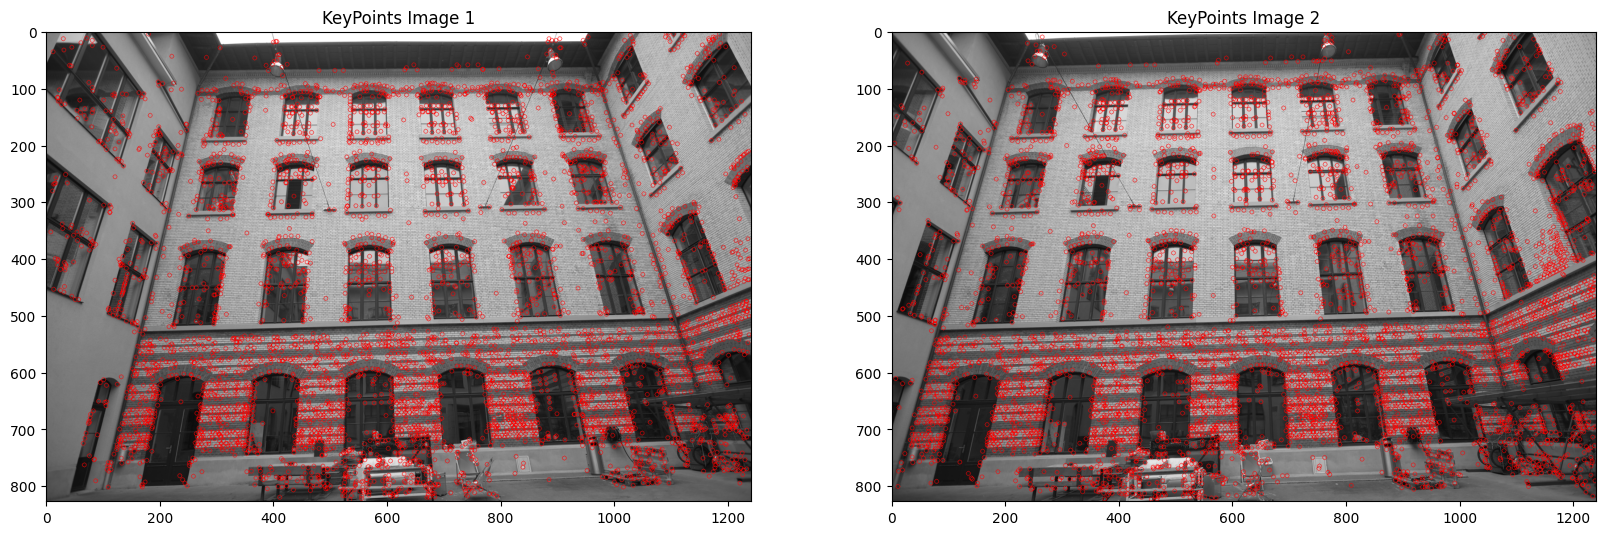

In [247]:
# Create copies of the original images to avoid modifying them directly
img1_with_circles = img1.copy()
img2_with_circles = img2.copy()

# Define circle parameters
circle_color = (255, 0, 0)  # Green color for the circle
circle_radius = 4  # Radius of the circle
circle_thickness = 1  # Thickness of the circle's outline

# Iterate through each keypoint in keypoints_1 and draw a circle on img1_with_circles
for kp in keypoints_1:
    center_coordinates = (int(kp.pt[0]), int(kp.pt[1]))  # Convert the float coordinates to integer
    cv2.circle(img1_with_circles, center_coordinates, circle_radius, circle_color, circle_thickness)

# Iterate through each keypoint in keypoints_2 and draw a circle on img2_with_circles
for kp in keypoints_2:
    center_coordinates = (int(kp.pt[0]), int(kp.pt[1]))  # Convert the float coordinates to integer
    cv2.circle(img2_with_circles, center_coordinates, circle_radius, circle_color, circle_thickness)

# Display the images with circles marking the keypoints
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1), plt.imshow(img1_with_circles), plt.title('KeyPoints Image 1')
plt.subplot(1, 2, 2), plt.imshow(img2_with_circles), plt.title('KeyPoints Image 2')
plt.show()

<font color=blue>2.Now we gonna find the Matches bettwen the 2 images using the cv2.BFMatcher

In [248]:
# Step 1: Initialize the BFMatcher
bf = cv2.BFMatcher()

# Step 2: Match descriptors
k = 2 # For example, finding the 2 best matches
matches = bf.knnMatch(descriptors_1, descriptors_2, k=k)

# Step 3: Sort them in the order of their distance
# Optional: Filter matches using the Lowe's ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.58*n.distance:
        good_matches.append(m)
        
print(len(good_matches))        

1584


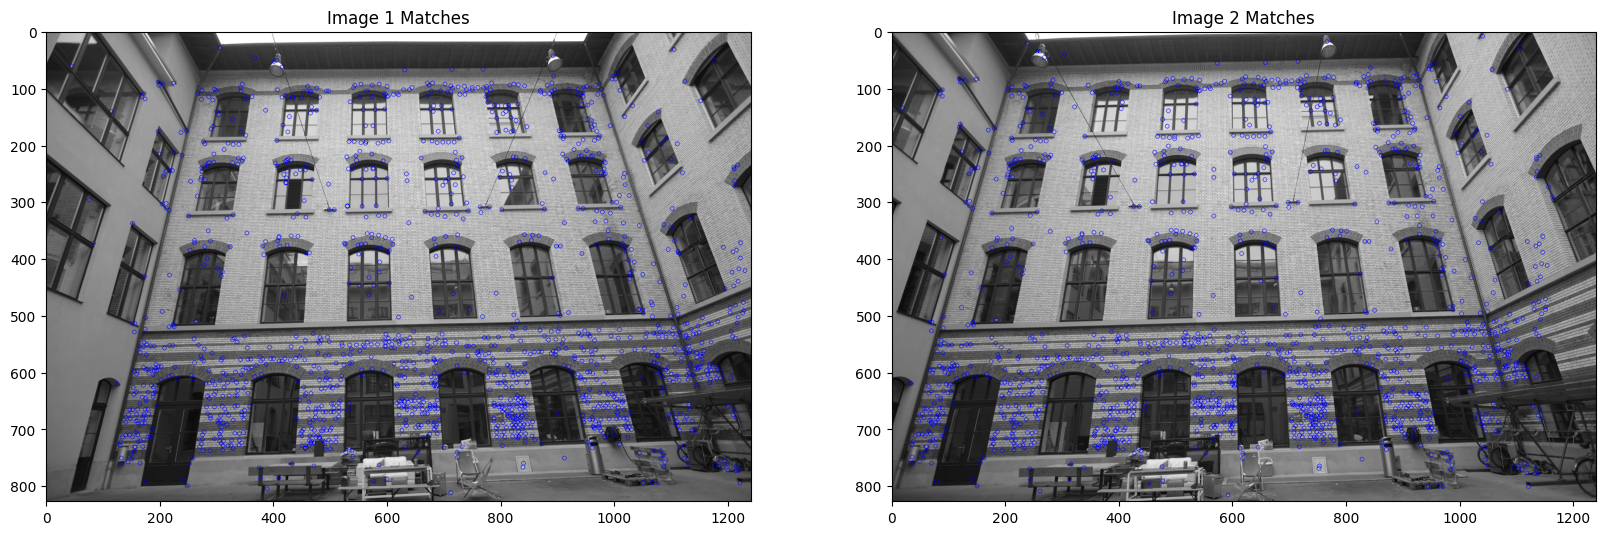

In [249]:

# Create copies of the original images to draw on
img1_with_matches = img1.copy()
img2_with_matches = img2.copy()

# Radius and color for the circles
radius = 4  # Radius of the circle
color = (255, 0, 0)  # Green color for the circle
thickness = 1  # Thickness of the circle border. -1 indicates to fill the circle

for match in good_matches:
    # Get the matching keypoints for each of the images
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    
    # Get the coordinates
    (x1, y1) = keypoints_1[img1_idx].pt
    (x2, y2) = keypoints_2[img2_idx].pt
    
    # Draw a small circle at both co-ordinates
    cv2.circle(img1_with_matches, (int(x1), int(y1)), radius, color, thickness)
    cv2.circle(img2_with_matches, (int(x2), int(y2)), radius, color, thickness)


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_with_matches, cv2.COLOR_BGR2RGB))
plt.title('Image 1 Matches')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_with_matches, cv2.COLOR_BGR2RGB))
plt.title('Image 2 Matches')

plt.show()

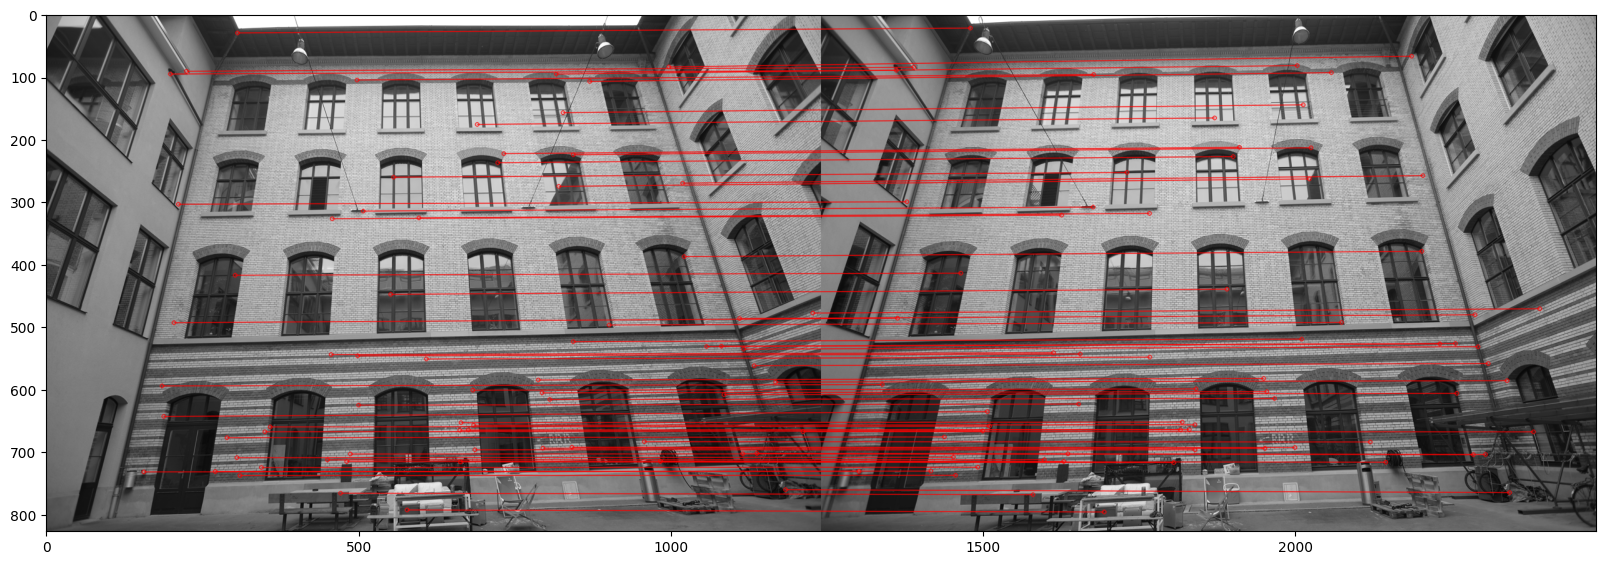

In [250]:

import random


img1_with_lines = img1.copy()
img2_with_lines = img2.copy()

# Step 4: Draw the first 80 matches with better visibility and specified color and thickness
num_matches_to_draw = 70
best_matches = random.sample(good_matches, num_matches_to_draw)
# Specify matchColor for all lines (BGR format) and thickness
matchColor = (255, 0, 0) 
lineThickness = 1 # Decrease line thickness for less bold lines


img_matches = cv2.drawMatches(img1_with_lines, keypoints_1, img2_with_lines, keypoints_2, best_matches, None, 
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                              matchColor=matchColor, singlePointColor=None, matchesThickness=lineThickness)

# Display the matches with increased figure size for better visibility
plt.figure(figsize=(20,10))
plt.imshow(img_matches)
plt.show()

In [251]:
import numpy as np


K_mat_path = 'example_1/K.txt'
K_mat = np.loadtxt(K_mat_path, delimiter=',')

matching_keypoints_1 = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches])
matching_keypoints_2 = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches])

# Find the Fundamental matrix and the mask for inliers
F, mask = cv2.findFundamentalMat(matching_keypoints_1, matching_keypoints_2, cv2.FM_RANSAC)

# Filter keypoints based on the mask
filtered_good_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]


# Recompute matching keypoints using filtered good matches
matching_keypoints_1 = np.float32([keypoints_1[m.queryIdx].pt for m in filtered_good_matches])
matching_keypoints_2 = np.float32([keypoints_2[m.trainIdx].pt for m in filtered_good_matches])
# Recompute the Essential matrix using only inliers if necessary
# Note: This step is optional and depends on your specific requirements
E = K_mat.T @ F @ K_mat

# Print the Fundamental matrix
print("Fundamental matrix:")
print(F)

# Print the Essential matrix
print("\nEssential matrix:")
print(E)

# Optionally, print the number of inliers
print("\nNumber of inliers:", len(filtered_good_matches))

Fundamental matrix:
[[-7.29928904e-08 -5.39869709e-05  3.22633880e-02]
 [ 5.95275133e-05 -3.38793050e-06 -2.23027355e-01]
 [-3.51112846e-02  2.22332788e-01  1.00000000e+00]]

Essential matrix:
[[-3.39423824e-02 -2.51034198e+01  6.76747580e+00]
 [ 2.76797185e+01 -1.57529026e+00 -1.27744108e+02]
 [-7.21133876e+00  1.27716358e+02 -2.41744902e-01]]

Number of inliers: 1506


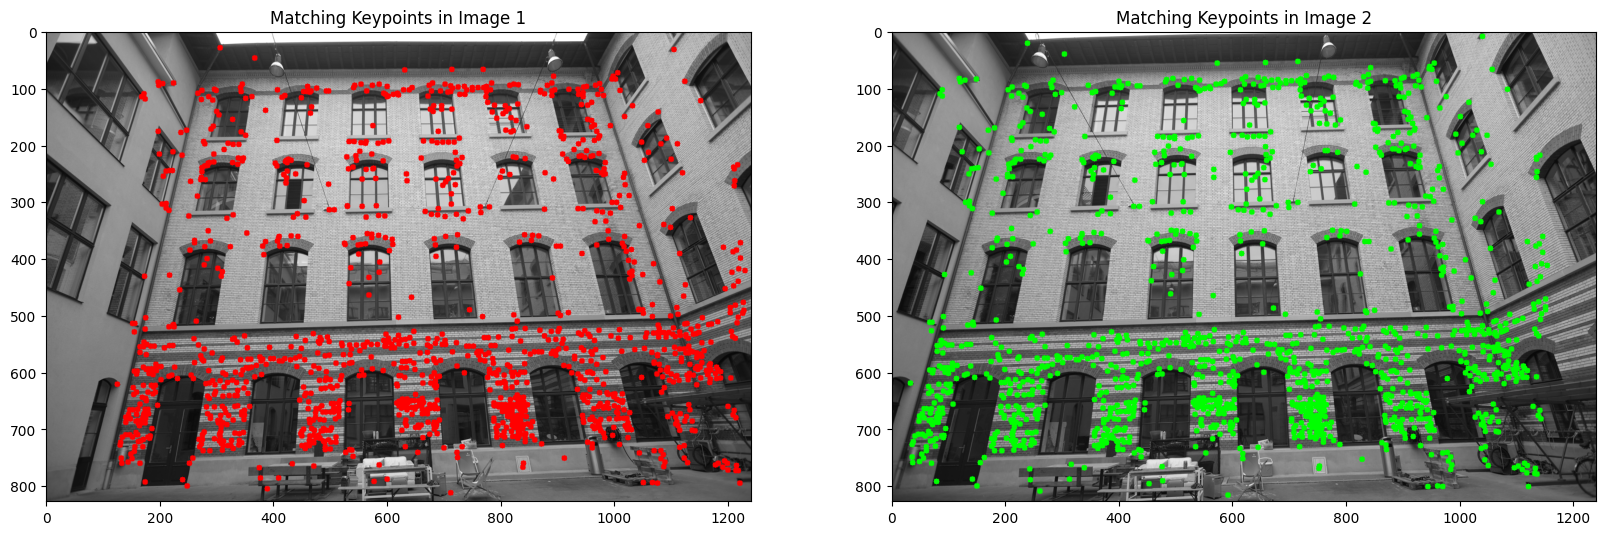

In [252]:

img1_inliners_ponits = img1.copy()
img2_inliners_ponits = img2.copy()


for point in matching_keypoints_1:
    x, y = point.ravel()
    cv2.circle(img1_inliners_ponits, (int(x), int(y)), 5, (255, 0, 0), -1)

for point in matching_keypoints_2:
    x, y = point.ravel()
    cv2.circle(img2_inliners_ponits, (int(x), int(y)), 5, (0, 255, 0), -1)

# Display the images
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1), plt.imshow(img1_inliners_ponits), plt.title('Matching Keypoints in Image 1')
plt.subplot(1, 2, 2), plt.imshow(img2_inliners_ponits), plt.title('Matching Keypoints in Image 2')
plt.show()



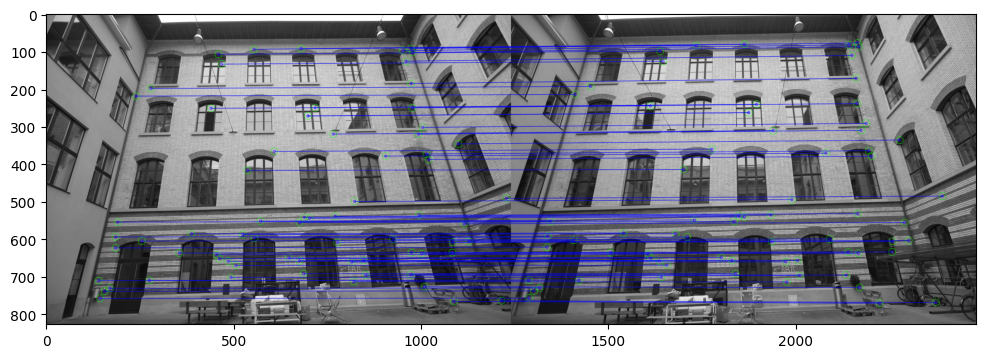

In [253]:
img1_Lines_inliers = img1.copy()
img2_Lines_inliers = img2.copy()

# Filter matches based on the mask to get only inliers
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i,0]]

num_matches_to_draw = 70
inlier_matches = random.sample(inlier_matches, num_matches_to_draw)

# Iterate through the inlier matches to draw bold circles around keypoints
for match in inlier_matches:
    pt1 = tuple(np.round(keypoints_1[match.queryIdx].pt).astype(int))
    pt2 = tuple(np.round(keypoints_2[match.trainIdx].pt).astype(int))

    # Draw bold circles around keypoints
    cv2.circle(img1_Lines_inliers, pt1, 10, (0, 255, 0), 1)  # Green circle in img1, radius=10, thickness=3
    cv2.circle(img2_Lines_inliers, pt2, 10, (0, 255, 0), 1)  # Green circle in img2, radius=10, thickness=3

matchColor = (0, 0, 255)  # Blue, Green, Red format
lineThickness = 1  # Set the thickness of the lines
img_matches = cv2.drawMatches(img1_Lines_inliers, keypoints_1, img2_Lines_inliers, keypoints_2, inlier_matches, None, 
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                              matchColor=matchColor, matchesThickness=lineThickness)

# Display the matches
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.show()

In [254]:
def draw_lines(img, lines, pts):
    r, c = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for r, pt in zip(lines, pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img = cv2.line(img, (x0, y0), (x1, y1), color, 1)
        pt = tuple(map(int, pt))  # Ensure the point is a tuple of integers
        img = cv2.circle(img, pt, 5, color, -1)
    return img

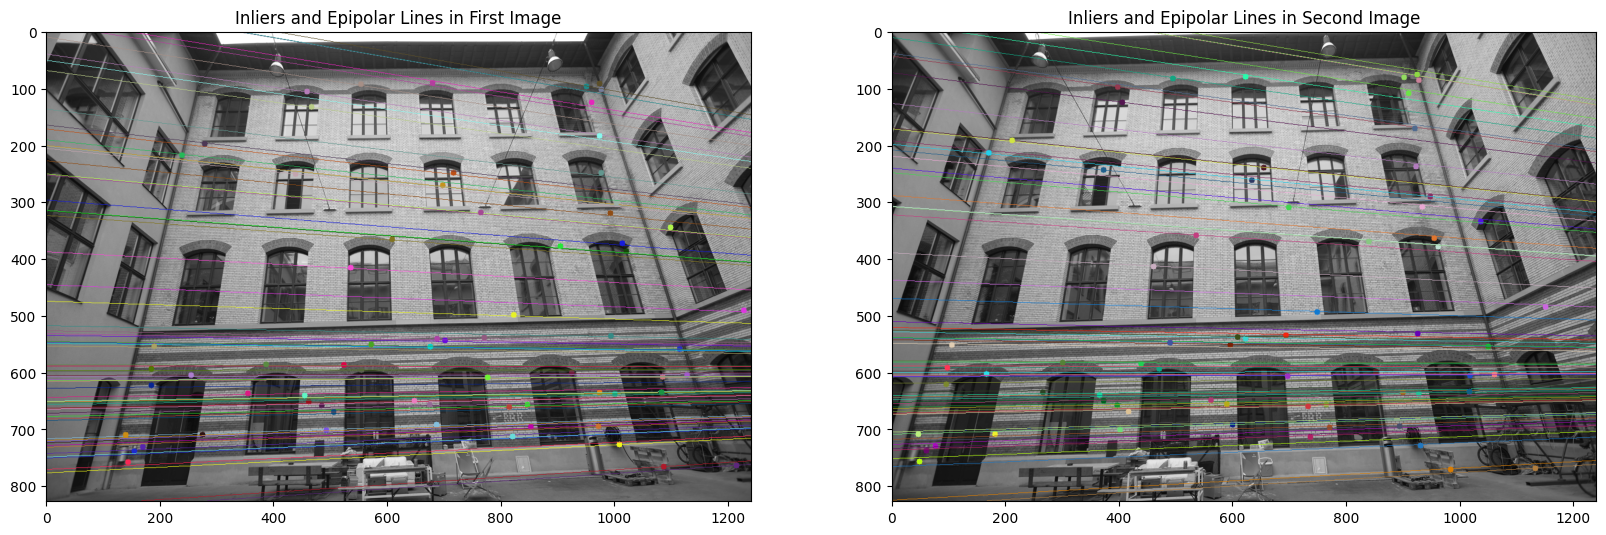

In [255]:

p1 = np.float32([keypoints_1[m.queryIdx].pt for m in inlier_matches])
p2 = np.float32([keypoints_2[m.trainIdx].pt for m in inlier_matches])

# compute the epi
lines1 = cv2.computeCorrespondEpilines(p1.reshape(-1, 1, 2), 2, F)
lines2 = cv2.computeCorrespondEpilines(p2.reshape(-1, 1, 2), 1, F)
lines1 = lines1.reshape(-1, 3)
lines2 = lines2.reshape(-1, 3)

# convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# draw the lines
img1_lines = draw_lines(img1_gray, lines1, p1)
img2_lines = draw_lines(img2_gray, lines2, p2)

# show
plt.figure(figsize=(20, 10))
plt.subplot(121), plt.imshow(img1_lines)
plt.title('Inliers and Epipolar Lines in First Image')
plt.subplot(122), plt.imshow(img2_lines)
plt.title('Inliers and Epipolar Lines in Second Image')
plt.show()